In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
from progressbar import progressbar

In [2]:
0.000664239512*0.6022*1e6

400.00503412639995

# Selectivity theory v.s. NERDSS

In [3]:
import sys
from scipy.optimize import fsolve, root_scalar
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.doubleS import rxnNetwork as rxnDoubleS, labels as labelsDoubleS
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [4]:
GenParms = lambda NP0, NS, scale, KPP: GenParameters(
    numTargets=NS, NP0=NP0, KPP=[KPP], KPN=[10], area3Dto1D=[10], lengthScale=scale
)

In [5]:
def freeProDiff(NP1, Ntot = 2, NS = 2, scale = 2, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return -((Ntot-N1)*(1-theta2))[0]
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return (N1*(1-theta1) - (Ntot-N1)*(1-theta2))[0]
    
def pBoundRatios(NP1, Ntot = 2, NS = 2, scale = 2, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return 0, theta2
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return theta1, theta2
    
def proteinsOnDNA(N1, Ntot, theta1, theta2):
    return theta1*(N1), theta2*(Ntot - N1)

In [6]:
KPPList = 10.0**np.arange(0,7.01,0.25)
N1_dimer = []

for Ntot in [2, 4]:
    N1_n = []
    for kpp in progressbar(KPPList):
        r_dimer = root_scalar(freeProDiff, x0=Ntot/2, x1=Ntot/2*0.9, xtol=1e-6, args=(Ntot, 2, 2, kpp))
        N1_n.append(r_dimer.root)
    N1_dimer.append(N1_n)

N1_dimer = np.array(N1_dimer)

100% (29 of 29) |########################| Elapsed Time: 0:00:23 Time:  0:00:23
100% (29 of 29) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


In [7]:
theta1 = []
theta2 = []
clustered_onDNA = []
separated_onDNA = []
for i, Ptot in enumerate([2, 4]):
    th1_n = []
    th2_n = []
    spr_n = []
    cls_n = []
    for j in progressbar(range(len(KPPList))):
        kpp = KPPList[j]
        th1, th2 = pBoundRatios(N1_dimer[i][j], Ptot, 2, 2, kpp)
        spr, cls = proteinsOnDNA(N1_dimer[i][j], Ptot, th1, th2)
        cls_n.append(cls)
        spr_n.append(spr)
        th1_n.append(th1)
        th2_n.append(th2)
    clustered_onDNA.append(cls_n)
    separated_onDNA.append(spr_n)
    theta1.append(th1_n)
    theta2.append(th2_n)
clustered_onDNA = np.array(clustered_onDNA)
separated_onDNA = np.array(separated_onDNA)
theta1 = np.array(theta1)
theta2 = np.array(theta2)

100% (29 of 29) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (29 of 29) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


In [26]:
# NERDSS results
slcList_repeats_2pro = [[0.7846134133371219, 1.1148256877425806, 3.226054260749391, 29.900123663086855, 189.86720995670993, 328.83102380952386, 716.3366904761904], 
                        [0.08059040750221995, 0.1138934291917021, 0.3452691124787163, 5.3201632313452265, 137.15285469713717, 249.43847606756407, 319.90795991151896]]
slcList_repeats_4pro =  [[0.7839380458445123, 1.608361702731444, 2.4142460159166124, 3.017057706286011, 2.75540309837026, 2.2933347821954073, 3.4153309304606063], 
                         [0.06433321086749408, 0.12193825141052676, 0.15954401742176008, 0.21645287528201054, 0.12229826213536317, 0.09116039107861558, 0.14586540127521788]]
slcList_repeats = [slcList_repeats_2pro, slcList_repeats_4pro]

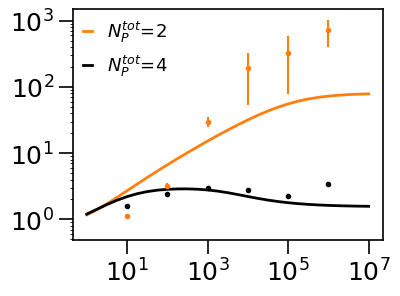

In [27]:
alphas = [1/3, 1]
colors = ['tab:orange', 'black']
plt.figure(figsize=(4,3))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)
    
for i, slcRepeat in enumerate(slcList_repeats):
    plt.errorbar(
        np.array([0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]), 
        slcRepeat[0], slcRepeat[1], 
        ls='', color=colors[i], marker='.', #edgecolors='black', alpha=alphas[1], 
    )
    
for i, ntot in enumerate([2, 4]):
    plt.plot(
        KPPList, ((clustered_onDNA/separated_onDNA))[i], ls='-', 
        label='$N_P^{tot}$=%d'%ntot, lw=2, color=colors[i], #color='tab:orange', alpha=alphas[i], 
        zorder=1,
    )


# plt.title('proteins on DNA', fontsize=13)
plt.legend(loc=[0.01,0.67], fontsize=13, handlelength=0.5, framealpha=0)
plt.loglog()
# plt.ylim([0.,1.01])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# Selectivity - NERDSS spatial

see Rockfish under folder twosegments